# Regressionanalyse Youtube Zielvariable Views

LAden der Pickle-Objekte aus der Datenvorverarbeitung

Daten erfolgreich geladen!

Trainings-Set Dimensionen:
X_train: (1012, 42)
y_train: (1012, 3)

Feature-Spalten:
['video_id', 'title', 'publish_date', 'video_length_seconds', 'wiedergabezeit_minuten', 'durchschnittliche_wiedergabedauer_prozent', 'gewonnene_abonnenten', 'verlorene_abonnenten', 'likes', 'dislikes', 'geteilte_inhalte', 'kommentare', 'audience_female_age18-24', 'audience_male_age18-24', 'audience_female_age25-34', 'audience_male_age25-34', 'audience_female_age35-44', 'audience_male_age35-44', 'audience_female_age45-54', 'audience_male_age45-54', 'audience_female_age55-64', 'audience_male_age55-64', 'audience_female_age65-', 'audience_male_age65-', 'audience_female_age13-17', 'audience_male_age13-17', 'Neue Zuschauer', 'Klicks auf Abspannelement', 'Klicks auf Infokartenteaser', 'Klicks auf Infokarte', '\x84Mag ich nicht\x93-Bewertungen', 'Im Feed angezeigt', 'Impressionen', 'Thema', 'Bewertung_Titel', 'Gestaltung_Thumbnail', 'theme_Bilder', 'theme_Krieg', 'theme_Live', 'them

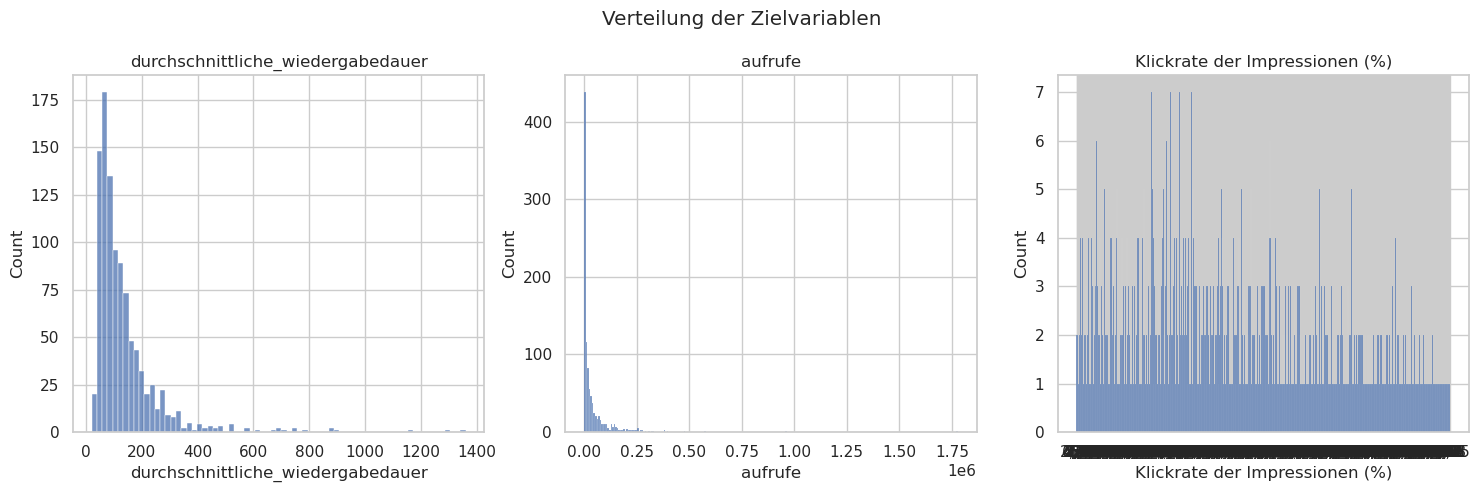

In [22]:

# Zelle 1: Setup und Imports
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Plotstil festlegen (verwenden einen basic matplotlib style)
plt.style.use('default')
# Seaborn Plotting Style setzen
sns.set_theme(style="whitegrid")

%matplotlib inline

plt.rcParams['font.family'] = 'DejaVu Sans'  # Alternativ: 'Liberation Sans', 'Arial Unicode MS'

# Display-Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Zelle 2: Laden der vorverarbeiteten Daten
# Laden der Pickle-Datei
with open('../data/processed/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Extrahieren der einzelnen Komponenten
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
#scaler = data['scaler']
feature_columns = data['feature_columns']
target_columns = data['target_columns']

# Überprüfung der geladenen Daten
print("Daten erfolgreich geladen!")
print(f"\nTrainings-Set Dimensionen:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"\nFeature-Spalten:")
print(feature_columns)
print(f"\nZiel-Spalten:")
print(target_columns)

# Zelle 3: Kurze Dateninspektion
# Überblick über die Feature-Verteilungen
print("\nStatistische Kennzahlen der Features im Trainingsset:")
print(X_train.describe())

# Überblick über die Zielvariblen
print("\nStatistische Kennzahlen der Zielvariablen im Trainingsset:")
print(y_train.describe())

# Visualisierung der Verteilung der Zielvariablen
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Verteilung der Zielvariablen')

for i, col in enumerate(target_columns):
    sns.histplot(data=y_train, x=col, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

### Funktionsdefinition für Analyse der Prädiktoren

In [23]:
def analyze_features_for_target(X_train, y_train, target_name, feature_columns):
    """
    Führt eine umfassende Feature-Analyse für eine Zielvariable durch
    """
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.linear_model import Lasso
    from sklearn.impute import SimpleImputer
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Nur numerische Spalten auswählen
    numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    X_numeric = X_train[numeric_features]
    
    # Imputation der fehlenden Werte
    imputer = SimpleImputer(strategy='mean')
    X_numeric_imputed = pd.DataFrame(
        imputer.fit_transform(X_numeric),
        columns=X_numeric.columns
    )
    
    target = y_train[target_name]
    results = {}
    
    # 1. F-Regression
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_numeric_imputed, target)
    
    f_scores = pd.DataFrame({
        'Feature': numeric_features,
        'F_Score': selector.scores_,
        'P_Value': selector.pvalues_
    }).sort_values('F_Score', ascending=False)
    
    results['f_scores'] = f_scores
    
    # 2. Lasso
    lasso = Lasso(alpha=0.01)
    lasso.fit(X_numeric_imputed, target)
    
    lasso_importance = pd.DataFrame({
        'Feature': numeric_features,
        'Coefficient': np.abs(lasso.coef_)
    }).sort_values('Coefficient', ascending=False)
    
    results['lasso'] = lasso_importance
    
    # 3. Korrelationsanalyse
    correlation_matrix = X_numeric_imputed.corr()
    high_correlations = np.where(np.abs(correlation_matrix) > 0.7)
    high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y], 
                        correlation_matrix.iloc[x, y])
                       for x, y in zip(*high_correlations) 
                       if x != y and x < y]
    
    results['high_correlations'] = high_corr_pairs
    
    # Visualisierungen
    plt.figure(figsize=(12, 6))
    sns.barplot(data=f_scores.head(10), x='F_Score', y='Feature')
    plt.title(f'Top 10 Features nach F-Score für {target_name}')
    plt.tight_layout()
    plt.show()
    
    return results

Ursprüngliche Datengröße: 1012
Gefilterte Datengröße: 852


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e+10, tolerance: 7.486e+08
  model = cd_fast.enet_coordinate_descent(


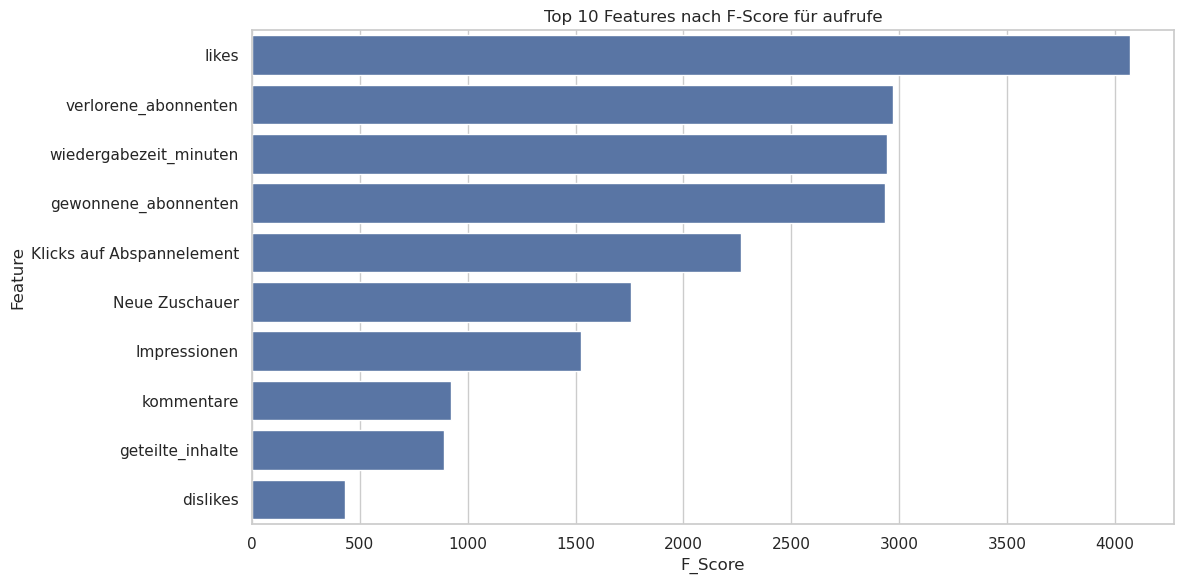


Top 10 Features nach F-Score:
                      Feature      F_Score        P_Value
5                       likes  4071.240792   0.000000e+00
4        verlorene_abonnenten  2971.242627  1.142018e-279
1      wiedergabezeit_minuten  2942.023888  2.984758e-278
3        gewonnene_abonnenten  2936.033062  5.845742e-278
24  Klicks auf Abspannelement  2266.493247  5.023199e-242
23             Neue Zuschauer  1758.841562  3.429543e-209
29               Impressionen  1523.546022  9.820402e-192
8                  kommentare   921.170631  1.177515e-137
7            geteilte_inhalte   891.024653  1.749958e-134
6                    dislikes   432.713284   5.248541e-78

Top 10 Features nach Lasso-Koeffizienten:
                     Feature   Coefficient
21  audience_female_age13-17  14356.842783
22    audience_male_age13-17   8891.895381
9   audience_female_age18-24   6938.655469
4       verlorene_abonnenten   3228.312482
10    audience_male_age18-24   1634.347373
31      Gestaltung_Thumbnail  

In [24]:
# Daten ohne Live-Content filtern
X_train_filtered = X_train[X_train['theme_Live'] == 0].copy()
y_train_filtered = y_train.loc[X_train_filtered.index]

print("Ursprüngliche Datengröße:", len(X_train))
print("Gefilterte Datengröße:", len(X_train_filtered))

# Feature-Analyse mit gefilterten Daten
results = analyze_features_for_target(X_train_filtered, y_train_filtered, 'aufrufe', feature_columns)

# Ausgabe der Ergebnisse
print("\nTop 10 Features nach F-Score:")
print(results['f_scores'].head(10))

print("\nTop 10 Features nach Lasso-Koeffizienten:")
print(results['lasso'].head(10))

print("\nStark korrelierte Features:")
for pair in results['high_correlations']:
    print(f"{pair[0]} -- {pair[1]}: {pair[2]:.3f}")

# Korrelation der Titelbewertung mit Aufrufen
correlation = X_train_filtered['Bewertung_Titel'].corr(y_train_filtered['aufrufe'])
print("\nKorrelation Titelbewertung mit Aufrufen:", correlation)

Analyse Kennzahlen wie F-Test oder p-Wert zwischen Aufrufen und BEwertung_Titel

In [ ]:
# Spezifische Analyse der Thumbnail-Bewertung
print("Position der Bewertung_Titel in den F-Scores:")
thumbnail_f_score = results['f_scores'][results['f_scores']['Feature'] == 'Bewertung_Titel']
print(thumbnail_f_score)

print("\nPosition der Bewertung_Titel in den Lasso-Koeffizienten:")
thumbnail_lasso = results['lasso'][results['lasso']['Feature'] == 'Bewertung_Titel']
print(thumbnail_lasso)

# Korrelation mit Aufrufen
correlation = X_train_filtered['Bewertung_Titel'].corr(y_train_filtered['aufrufe'])
print("\nKorrelation Bewertung_Titel mit Aufrufen:", correlation)

# Zusätzliche Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(X_train_filtered['Bewertung_Titel'], y_train_filtered['aufrufe'], alpha=0.5)
plt.xlabel('Bewertung_Titel (Bewertung)')
plt.ylabel('Aufrufe')
plt.title('Zusammenhang zwischen Bewertung_Titel und Aufrufen')
plt.show()

In [ ]:
# Daten ohne Live-Content filtern
X_train_filtered = X_train[X_train['theme_Live'] == 0].copy()
y_train_filtered = y_train.loc[X_train_filtered.index]

print("Ursprüngliche Datengröße:", len(X_train))
print("Gefilterte Datengröße:", len(X_train_filtered))

# Prüfen des Datentyps der Klickrate
print("\nDatentyp der Klickrate:")
print(y_train_filtered['Klickrate der Impressionen (%)'].dtype)

# Konvertierung der Klickrate in numerischen Typ
klickrate = pd.to_numeric(y_train_filtered['Klickrate der Impressionen (%)'].str.replace(',', '.').str.replace('%', ''), errors='coerce')

# Temporäres DataFrame für die Analyse
y_train_temp = pd.DataFrame({'klickrate': klickrate})

# Analyse der Klickrate
results_ctr = analyze_features_for_target(X_train_filtered, y_train_temp, 'klickrate', feature_columns)

print("\nTop Features für Klickrate:")
print(results_ctr['f_scores'].head(10))

# Spezifische Analyse Thumbnail/Titel auf Klickrate
correlation_thumbnail = X_train_filtered['Gestaltung_Thumbnail'].corr(klickrate)
correlation_titel = X_train_filtered['Bewertung_Titel'].corr(klickrate)

print("\nKorrelationen mit Klickrate:")
print(f"Thumbnail-Gestaltung: {correlation_thumbnail}")
print(f"Titel-Bewertung: {correlation_titel}")

Aufgrund der anderen Analysen scheinen mir die Prädiktoren auf die man Einfluss hat, keine wirkliche Rolle zu spielen. Den Titel kann ich beeinflussen und auch die Gestaltung der Thumbnails und natürlich die Länge der Videos. Das scheint mir nicht sinnvoll. Jeder weiß, dass der richtige Titel und vor allem ein gut gestaltetes Thumbnail entscheidende Faktoren sind

1. **Mögliche Gründe für die scheinbar geringen Effekte:**

**Bewertungssystem könnte zu grob sein:**
   - Die dreistufige Bewertung der Thumbnails (1,2,3) könnte zu undifferenziert sein
   - Die Komplexität guter Thumbnail-Gestaltung (Bildkomposition, Farbwahl, Textplatzierung, etc.) lässt sich möglicherweise nicht in drei Kategorien erfassen
   - Ähnliches gilt für die Titelbewertung durch die KI

**Zeitliche Dimension fehlt:**
   - Wir sehen nur die Endergebnisse der Videos
   - Die initiale Anziehungskraft von Thumbnail und Titel (die ersten Stunden/Tage) könnte in den Gesamtdaten untergehen
   - Der "First-Click-Effect" wird möglicherweise nicht richtig erfasst

**Indirekte Effekte werden nicht erfasst:**
   - Ein gutes Thumbnail führt zu mehr Klicks -> mehr Engagement -> bessere algorithmische Verbreitung
   - Diese Kausalkette wird in der einfachen Korrelationsanalyse nicht sichtbar

2. **Vorschlag für eine verfeinerte Analyse:**

**Zeitliche Analyse:**
   - Untersuchung der ersten 24/48 Stunden nach Veröffentlichung
   - Vergleich der Initial-Performance (wo Thumbnail/Titel den größten Einfluss haben sollten)

**Detailliertere Thumbnail-Bewertung:**
   - Mehr Kategorien (z.B. 5 oder 7 Stufen)
   - Separate Bewertung verschiedener Aspekte (Gesichter, Text, Kontrast, etc.)

**Klickraten-Analyse:**
   - Fokus auf das Verhältnis Impressionen/Klicks
   - Dies sollte den direkten Einfluss von Thumbnail und Titel besser zeigen

3. **Methodische Anpassung:**
   - Entwicklung eines komplexeren Bewertungssystems für Thumbnails
   - Berücksichtigung von Interaktionseffekten zwischen Titel und Thumbnail
   - Einbeziehung von zeitbasierten Metriken



In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def convert_german_number(x):
    """Konvertiert deutsche Zahlenformate (Komma als Dezimaltrennzeichen) in Float"""
    if isinstance(x, str):
        return float(x.replace(',', '.'))
    return x

def analyze_thumbnail_title_impact(X, y):
    # Erstellen eines DataFrames mit relevanten Spalten und Konvertierung der Zahlenformate
    analysis_df = pd.DataFrame({
        'Klickrate': y['Klickrate der Impressionen (%)'].apply(convert_german_number),
        'Thumbnail': X['Gestaltung_Thumbnail'],
        'Titelbewertung': X['Bewertung_Titel'].apply(convert_german_number)
    })
    
    # Grundlegende statistische Analyse
    print("\nStatistische Zusammenfassung:")
    print(analysis_df.describe())
    
    # Korrelationsanalyse
    correlations = analysis_df.corr()
    print("\nKorrelationsmatrix:")
    print(correlations)
    
    # ANOVA für Thumbnail-Kategorien
    thumbnail_groups = [group for _, group in analysis_df.groupby('Thumbnail')['Klickrate']]
    if len(thumbnail_groups) >= 2:  # ANOVA benötigt mindestens 2 Gruppen
        f_stat, p_val = stats.f_oneway(*thumbnail_groups)
        print("\nANOVA Test für Thumbnail-Kategorien:")
        print(f"F-Statistik: {f_stat:.4f}")
        print(f"P-Wert: {p_val:.4f}")
    
    # Durchschnittliche Klickrate pro Thumbnail-Kategorie
    avg_by_thumbnail = analysis_df.groupby('Thumbnail')['Klickrate'].agg(['mean', 'std', 'count'])
    print("\nDurchschnittliche Klickrate nach Thumbnail-Kategorie:")
    print(avg_by_thumbnail)
    
    # Visualisierungen
    plt.figure(figsize=(15, 5))
    
    # 1. Boxplot für Thumbnail-Kategorien
    plt.subplot(131)
    sns.boxplot(x='Thumbnail', y='Klickrate', data=analysis_df)
    plt.title('Klickrate nach Thumbnail-Kategorie')
    plt.xlabel('Thumbnail-Bewertung')
    plt.ylabel('Klickrate (%)')
    
    # 2. Scatterplot für Titelbewertung
    plt.subplot(132)
    sns.scatterplot(x='Titelbewertung', y='Klickrate', data=analysis_df)
    plt.title('Klickrate vs. Titelbewertung')
    plt.xlabel('Titelbewertung')
    plt.ylabel('Klickrate (%)')
    
    # 3. Kombinierter Violinplot
    plt.subplot(133)
    sns.violinplot(x='Thumbnail', y='Klickrate', data=analysis_df)
    plt.title('Verteilung der Klickrate nach Thumbnail')
    plt.xlabel('Thumbnail-Bewertung')
    plt.ylabel('Klickrate (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Regressionsanalyse für Titelbewertung
    X_title = analysis_df['Titelbewertung'].values.reshape(-1, 1)
    y_click = analysis_df['Klickrate'].values
    
    model = LinearRegression()
    model.fit(X_title, y_click)
    
    r2 = r2_score(y_click, model.predict(X_title))
    
    print("\nRegression Titelbewertung -> Klickrate:")
    print(f"R²: {r2:.4f}")
    print(f"Steigung: {model.coef_[0]:.4f}")
    print(f"Y-Achsenabschnitt: {model.intercept_:.4f}")
    
    # Effektstärke berechnen (Cohen's d) für Thumbnail-Kategorien
    def cohens_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        if n1 < 2 or n2 < 2:  # Mindestens 2 Werte pro Gruppe erforderlich
            return np.nan
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(group1) - np.mean(group2)) / pooled_se if pooled_se != 0 else np.nan
    
    thumbnail_categories = sorted(analysis_df['Thumbnail'].unique())
    print("\nEffektstärken zwischen Thumbnail-Kategorien (Cohen's d):")
    for i in range(len(thumbnail_categories)):
        for j in range(i + 1, len(thumbnail_categories)):
            cat1 = thumbnail_categories[i]
            cat2 = thumbnail_categories[j]
            group1 = analysis_df[analysis_df['Thumbnail'] == cat1]['Klickrate']
            group2 = analysis_df[analysis_df['Thumbnail'] == cat2]['Klickrate']
            d = cohens_d(group1, group2)
            if not np.isnan(d):
                print(f"Kategorie {cat1} vs {cat2}: {d:.4f}")

# Zusätzliche Fehlerbehandlung
try:
    analyze_thumbnail_title_impact(X_test, y_test)
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {str(e)}")
    print("\nBitte überprüfen Sie die Datentypen:")
    print("\nX_test Datentypen:")
    print(X_test.dtypes)
    print("\ny_test Datentypen:")
    print(y_test.dtypes)

Ein Fehler ist aufgetreten: could not convert string to float: 'Politik'

Bitte überprüfen Sie die Datentypen:

X_test Datentypen:
video_id                                      object
title                                         object
publish_date                                  object
video_length_seconds                           int64
wiedergabezeit_minuten                         int64
durchschnittliche_wiedergabedauer_prozent    float64
gewonnene_abonnenten                         float64
verlorene_abonnenten                           int64
likes                                          int64
dislikes                                       int64
geteilte_inhalte                               int64
kommentare                                   float64
audience_female_age18-24                     float64
audience_male_age18-24                       float64
audience_female_age25-34                     float64
audience_male_age25-34                       float64
audience_female_age35

Dieser Code führt die Analyse mit drei verschiedenen Ansätzen durch:

1. Original-Daten ohne Ausreißerbehandlung
2. IQR-Methode (Interquartilsabstand)
   - Entfernt Datenpunkte, die mehr als 1,5 IQR von Q1/Q3 entfernt sind
   - Eine konservative Methode, die häufig in der Statistik verwendet wird

3. Z-Score-Methode
   - Entfernt Datenpunkte mit einem Z-Score > 2 (entspricht etwa 95% Konfidenzintervall)
   - Basiert auf der Annahme einer Normalverteilung

Für jede Methode werden durchgeführt:
- Deskriptive Statistiken
- Korrelationsanalyse
- ANOVA-Test
- Regressionsanalyse
- Visualisierungen

Die Entfernung von Ausreißern könnte besonders hilfreich sein, um:
1. Klarere Muster in den Daten zu erkennen
2. Robustere statistische Schätzungen zu erhalten
3. Die "typischen" Zusammenhänge besser zu verstehen

Möchten Sie, dass wir den Code ausführen und die Ergebnisse der verschiedenen Methoden vergleichen?

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys
from datetime import datetime
import os

class OutputCapture:
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.filename = filename

    def write(self, text):
        self.terminal.write(text)
        with open(self.filename, 'a', encoding='utf-8') as f:
            f.write(text)

    def flush(self):
        self.terminal.flush()

def convert_german_number(x):
    """Konvertiert deutsche Zahlenformate in Float"""
    if isinstance(x, str):
        return float(x.replace(',', '.'))
    return x

def remove_outliers(df, columns, method='iqr', threshold=1.5):
    """Entfernt Ausreißer basierend auf verschiedenen Methoden"""
    df_clean = df.copy()
    
    for column in columns:
        if method == 'iqr':
            Q1 = df_clean[column].quantile(0.25)
            Q3 = df_clean[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            mask = (df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(df_clean[column]))
            mask = z_scores < threshold
        
        df_clean = df_clean[mask]
    
    removed_count = len(df) - len(df_clean)
    print(f"\nEntfernte Datenpunkte: {removed_count} ({(removed_count/len(df)*100):.1f}%)")
    
    return df_clean

def analyze_with_outlier_treatment(X, y, methods=['original', 'iqr', 'zscore']):
    """Führt Analyse mit verschiedenen Ausreißerbehandlungen durch"""
    
    # Erstellen des Ausgabeordners
    output_dir = 'analysis_output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Ausgabedatei mit Zeitstempel erstellen
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = os.path.join(output_dir, f'analysis_results_{timestamp}.txt')
    
    # Umleiten der Ausgabe in Datei
    sys.stdout = OutputCapture(output_file)
    
    print("Analyse der YouTube-Metriken mit Ausreißerbehandlung")
    print(f"Durchgeführt am: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    
    # Erstellen des initialen DataFrames
    analysis_df = pd.DataFrame({
        'Klickrate': y['Klickrate der Impressionen (%)'].apply(convert_german_number),
        'Thumbnail': X['Gestaltung_Thumbnail'],
        'Titelbewertung': X['Bewertung_Titel'].apply(convert_german_number)
    })
    
    for method in methods:
        print(f"\n{'='*50}")
        print(f"Analyse mit {method.upper()} Methode")
        print('='*50)
        
        if method == 'original':
            df_analyzed = analysis_df
        elif method == 'iqr':
            df_analyzed = remove_outliers(analysis_df, ['Klickrate'], method='iqr', threshold=1.5)
        elif method == 'zscore':
            df_analyzed = remove_outliers(analysis_df, ['Klickrate'], method='zscore', threshold=2)
        
        # Statistische Analysen
        print("\nStatistische Zusammenfassung:")
        print(df_analyzed.describe())
        
        # Korrelationen
        correlations = df_analyzed.corr()
        print("\nKorrelationsmatrix:")
        print(correlations)
        
        # ANOVA
        thumbnail_groups = [group for _, group in df_analyzed.groupby('Thumbnail')['Klickrate']]
        f_stat, p_val = stats.f_oneway(*thumbnail_groups)
        print("\nANOVA Test:")
        print(f"F-Statistik: {f_stat:.4f}")
        print(f"P-Wert: {p_val:.4f}")
        
        # Durchschnittliche Klickrate pro Thumbnail
        avg_by_thumbnail = df_analyzed.groupby('Thumbnail')['Klickrate'].agg(['mean', 'std', 'count'])
        print("\nDurchschnittliche Klickrate nach Thumbnail-Kategorie:")
        print(avg_by_thumbnail)
        
        # Regression
        X_title = df_analyzed['Titelbewertung'].values.reshape(-1, 1)
        y_click = df_analyzed['Klickrate'].values
        model = LinearRegression()
        model.fit(X_title, y_click)
        r2 = r2_score(y_click, model.predict(X_title))
        
        print("\nRegression Titelbewertung -> Klickrate:")
        print(f"R²: {r2:.4f}")
        print(f"Steigung: {model.coef_[0]:.4f}")
        print(f"Y-Achsenabschnitt: {model.intercept_:.4f}")
        
        # Effektstärken zwischen Thumbnail-Kategorien
        print("\nEffektstärken zwischen Thumbnail-Kategorien (Cohen's d):")
        thumbnail_categories = sorted(df_analyzed['Thumbnail'].unique())
        for i in range(len(thumbnail_categories)):
            for j in range(i + 1, len(thumbnail_categories)):
                cat1, cat2 = thumbnail_categories[i], thumbnail_categories[j]
                group1 = df_analyzed[df_analyzed['Thumbnail'] == cat1]['Klickrate']
                group2 = df_analyzed[df_analyzed['Thumbnail'] == cat2]['Klickrate']
                d = (group1.mean() - group2.mean()) / np.sqrt((group1.var() + group2.var()) / 2)
                print(f"Kategorie {cat1} vs {cat2}: {d:.4f}")
        
        # Visualisierung speichern
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Analyse mit {method.upper()} Methode')
        
        sns.boxplot(x='Thumbnail', y='Klickrate', data=df_analyzed, ax=axes[0])
        axes[0].set_title('Klickrate nach Thumbnail')
        
        sns.scatterplot(x='Titelbewertung', y='Klickrate', data=df_analyzed, ax=axes[1])
        axes[1].set_title('Klickrate vs. Titelbewertung')
        
        sns.violinplot(x='Thumbnail', y='Klickrate', data=df_analyzed, ax=axes[2])
        axes[2].set_title('Verteilung der Klickrate')
        
        plt.tight_layout()
        plot_filename = os.path.join(output_dir, f'plot_{method}_{timestamp}.png')
        plt.savefig(plot_filename)
        plt.close()
        
        print(f"\nVisualisierung gespeichert als: {plot_filename}")
    
    print("\nAnalyse abgeschlossen. Ergebnisse wurden gespeichert in:", output_file)
    
    # Stdout zurücksetzen
    sys.stdout = sys.stdout.terminal

# Analyse durchführen
analyze_with_outlier_treatment(X_test, y_test)

Analyse der YouTube-Metriken mit Ausreißerbehandlung
Durchgeführt am: 2025-01-07 11:23:55


ValueError: could not convert string to float: 'Politik'